# Generative Adversarial Network
In this notebook, we use Keras with Tensorflow to implement a Generative Adversarial
Network with the MNIST dataset.

The code is based on this
[course](https://harvard-iacs.github.io/2019-CS109B/labs/lab11/GANS-sol/).

In [1]:
import sys
sys.version

'3.6.8 (default, Jan 14 2019, 11:02:34) \n[GCC 8.0.1 20180414 (experimental) [trunk revision 259383]]'

In [2]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import sys
import numpy as np
from tqdm import tqdm_notebook

Using TensorFlow backend.


* Dense — Refers to Dense layers which are layers where every neuron of the previous layer is connected to every neuron of the next input layer.
* Reshape — Helps us reshape the output of a layer to a specific shape.
* Flatten — Allows us to flatten the input by removing all of its dimensions except for 1. It’s essentially the operation of converting a Matrix into a simple array.
* Dropout — Is an essential technique to reduce the risks of overfitting our model. It achieves this by randomly setting the outgoing edges of hidden neurons to 0.
* BatchNormalization — This mechanism will allow us to train on a more stable distribution of inputs. This is achieved through standardizing our inputs to have a mean of 0 and a standard deviation of 1.
* Activation — Refers to our Activation functions, which essentially transform any input signal to an output signal for the next layer.
* LeakyRelu — Is a type of Activation function.
* Sequential — Refers to the type of model we’ll be building. This will allow us to build our model layer by layer.
* Adam — This is our Optimizer function.


[Reference](https://towardsdatascience.com/writing-your-first-generative-adversarial-network-with-keras-2d16fd8d4889)

In [3]:
# Dataset of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images.
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

Rescaling the data. Each image matrix is reshaped into a vector and the values are renormalized to
be between 0 and 1.

In [4]:
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

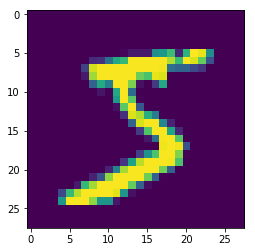

In [5]:
plt.imshow(X_train[0].reshape((28,28)))

#### Noise dimension

In [6]:
z_dim = 100

In [9]:
#@title
adam = Adam(lr=0.0002, beta_1=0.5)


#GENERATOR
g = Sequential()
g.add(Dense(256, input_dim=z_dim, activation=LeakyReLU(alpha=0.2)))
g.add(Dense(512, activation=LeakyReLU(alpha=0.2)))
g.add(Dense(1024, activation=LeakyReLU(alpha=0.2)))
g.add(Dense(784, activation='sigmoid'))  # Values between 0 and 1
g.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

#DISCRIMINATOR
d = Sequential()
d.add(Dense(1024, input_dim=784, activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(rate=0.3))
d.add(Dense(512, activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(rate=0.3))
d.add(Dense(256, activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(rate=0.3))
d.add(Dense(1, activation='sigmoid'))  # Values between 0 and 1
d.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

#GAN
d.trainable = False 
inputs = Input(shape=(z_dim, ))
hidden = g(inputs)
output = d(hidden)
# No código abaixo, estamos "concatenando" a rede G com a rede D, formando nossa GAN
gan = Model(inputs, output)
gan.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [10]:
def plot_loss(losses):
    """
    @losses.keys():
        0: loss
        1: accuracy
    """
    d_loss = [v[0] for v in losses["D"]]
    g_loss = [v[0] for v in losses["G"]]
    
    plt.figure(figsize=(10,8))
    plt.plot(d_loss, label="Discriminator loss")
    plt.plot(g_loss, label="Generator loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
def plot_generated(n_ex=10, dim=(1, 10), figsize=(12, 2)):
    noise = np.random.normal(0, 1, size=(n_ex, z_dim))
    generated_images = g.predict(noise)
    generated_images = generated_images.reshape(n_ex, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [22]:
losses = {"D":[], "G":[]}

def train(epochs=1, plt_frq=1, BATCH_SIZE=128):
    batchCount = int(X_train.shape[0] / BATCH_SIZE)
    print('Epochs:', epochs)
    print('Batch size:', BATCH_SIZE)
    print('Batches per epoch:', batchCount)
    
    for e in tqdm_notebook(range(1, epochs+1)):
        if e == 1 or e%plt_frq == 0:
            print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in range(batchCount):  # tqdm_notebook(range(batchCount), leave=False):
            # Create a batch by drawing random index numbers from the training set
            image_batch = X_train[np.random.randint(0, X_train.shape[0], size=BATCH_SIZE)]
            # Create noise vectors for the generator
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, z_dim))
            
            # Generate the images from the noise
            generated_images = g.predict(noise)
            X = np.concatenate((image_batch, generated_images))
            # Create labels
            y = np.zeros(2*BATCH_SIZE)
            y[:BATCH_SIZE] = 0.9  # One-sided label smoothing
                                  # utilizado para evitar que o descriminador se torne "overconfident",
                                  # evitando "mode collapse".

            # Train discriminator on generated images
            d.trainable = True
            d_loss = d.train_on_batch(X, y)

            # Train generator
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, z_dim))
            y2 = np.ones(BATCH_SIZE)
            d.trainable = False
            g_loss = gan.train_on_batch(noise, y2)

        # Only store losses from final
        losses["D"].append(d_loss)
        losses["G"].append(g_loss)

        # Update the plots
        if e == 1 or e%plt_frq == 0:
            plot_generated()
    plot_loss(losses)

Epochs: 200
Batch size: 128
Batches per epoch: 468


--------------- Epoch 1 ---------------


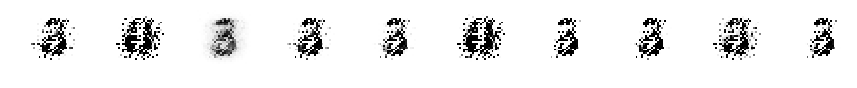

--------------- Epoch 40 ---------------


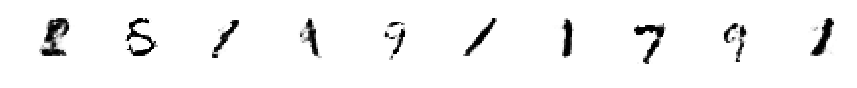

--------------- Epoch 80 ---------------


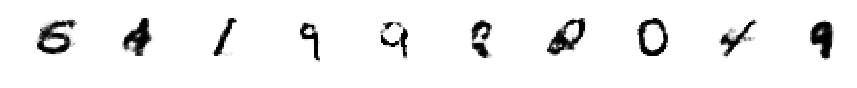

--------------- Epoch 120 ---------------


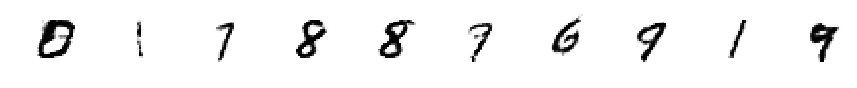

--------------- Epoch 160 ---------------


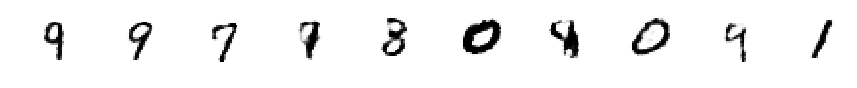

--------------- Epoch 200 ---------------


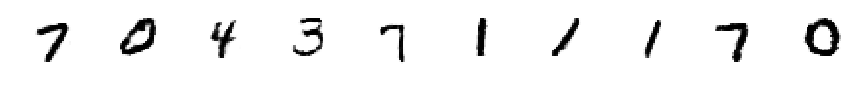

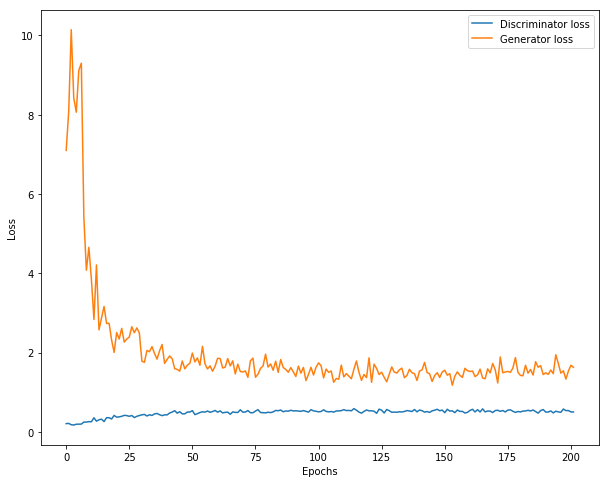

In [24]:
train(epochs=200, plt_frq=40, BATCH_SIZE=128)

In [26]:
gan.save_weights("gan_model.h5")
g.save_weights("generative_model.h5")
d.save_weights("discriminative_model.h5")

In [11]:
gan.load_weights("gan_model.h5")
g.load_weights("generative_model.h5")
d.load_weights("discriminative_model.h5")

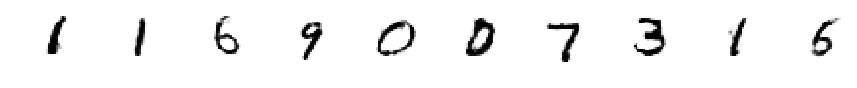

In [12]:
qtd = 10
noise = np.random.normal(0, 1, size=(qtd, z_dim))
generated_image = g.predict(noise)
# generated_image = generated_image.reshape(qtd, 28, 28)
plot_generated()

In [13]:
d.predict(X_train[10:20])

array([[0.5918873 ],
       [0.8654703 ],
       [0.78875196],
       [0.7515012 ],
       [0.28034043],
       [0.17006531],
       [0.9238237 ],
       [0.7270963 ],
       [0.7143301 ],
       [0.6872364 ]], dtype=float32)